# Different prior approaches 

In [1]:
import numpy as np
import pystan as ps
import stan_utility

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
sns.set()

import pickle
from tqdm.notebook import tqdm

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha

## The stan models

In [13]:
compiled = True        
model = '../models/sensitivity_specificity/spec_sens_model_logit_normal'
if compiled: sm_ln = pickle.load(open(model + '.pkl', 'rb'))
else: 
    sm_ln = ps.StanModel(file=model + '.stan')
    with open(model+'.pkl', 'wb') as f:
        pickle.dump(sm_ln, f)

compiled = True
model = '../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth'
if compiled: sm_cbb = pickle.load(open(model + '.pkl', 'rb'))
else: 
    sm_cbb = ps.StanModel(file=model + '.stan')
    with open(model+'.pkl', 'wb') as f:
        pickle.dump(sm_cbb, f)
        
compiled = True
model = '../models/sensitivity_specificity/spec_sens_model_random_alpha_smooth'
if compiled: sm_rbb = pickle.load(open(model + '.pkl', 'rb'))
else: 
    sm_rbb = ps.StanModel(file=model + '.stan')
    with open(model+'.pkl', 'wb') as f:
        pickle.dump(sm_rbb, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f87d4736359dff09d821daa83abc844 NOW.


## Experiments

In [7]:
def experiment(ro): 
    
    sens = ro.beta(100, 0.15/0.85 * 100) 
    spec = ro.beta(100, 0.2/0.8 * 100)
    n_neg = ro.poisson(50)
    n_pos = ro.poisson(50)
    y_pos = ro.binomial(n_pos, sens)
    y_neg = ro.binomial(n_neg, spec)
    
    return sens, spec, n_neg, n_pos, y_pos, y_neg

def evaluation(sens_post, spec_post, sens, spec): 
    
    hits = np.zeros(2)
    errors = np.zeros(2)
    
    hdi_sens = az.hdi(sens_post, hdi_prob=.75)
    hdi_spec = az.hdi(spec_post, hdi_prob=.75)
    if (sens > hdi_sens[0]) & (sens < hdi_sens[1]): 
        hits[0] += 1
    if (spec > hdi_spec[0]) & (spec < hdi_spec[1]): 
        hits[1] += 1
    errors[0] = (sens_post.mean() - sens)**2
    errors[1] = (spec_post.mean() - spec)**2
    
    return hdi_sens, hdi_spec, hits, errors

## Wrapper to the models

In [10]:
def independent_beta_model(n_neg, n_pos, y_pos, y_neg, parameters):
    
    a_s = parameters['a_s']
    b_s = parameters['b_s']
    a_e = parameters['a_e']
    b_e = parameters['b_e']
    sens_post = np.random.beta(a_s + y_pos, b_s + n_pos - y_pos, size=2000)
    spec_post = np.random.beta(a_e + y_neg, b_e + n_neg - y_neg, size=2000)
    
    return evaluation(sens_post, spec_post, sens, spec)

def logit_normal_model(n_neg, n_pos, y_pos, y_neg, parameters, stan_model):   

    data = {'n_pos':n_pos, 'n_neg':n_neg, 'Y_p':y_pos, 'Y_n':y_neg, 
            'mu_gamma': parameters['mu'], 'Sigma_gamma': parameters['Sigma']}
    fit = stan_model.sampling(data=data, iter=4000, control={'max_treedepth': 12})
    sens_post = fit.extract()['sens']
    spec_post = fit.extract()['spec']
    return evaluation(sens_post, spec_post, sens, spec)

def bivariate_beta_constant_model(n_neg, n_pos, y_pos, y_neg, parameters, stan_model): 
    
    m1 = parameters['m1']
    m2 = parameters['m2']
    v1 = parameters['v1']
    v2 = parameters['v2']
    rho = parameters['rho']
    alpha_hat = np.array(ParameterAlpha().mix_solver(m1, m2, v1, v2, rho))
    data = {'n_pos':n_pos, 'n_neg':n_neg, 'Y_p':y_pos, 'Y_n':y_neg, 
            'alpha_data':alpha_hat}
    fit = stan_model.sampling(data=data, iter=4000)
    sens_post = fit.extract()['sens']
    spec_post = fit.extract()['spec']

    return evaluation(sens_post, spec_post, sens, spec), alpha_hat

def bivariate_beta_random_model(n_neg, n_pos, y_pos, y_neg, parameters, alpha_hat, stan_model): 
    
    b = alpha_hat / parameters['var_alpha']
    a = alpha_hat * b 
    data = {'n_pos':n_pos, 'n_neg':n_neg, 'Y_p':y_pos, 'Y_n':y_neg, 
            'a':a, 'b':b}
    fit = stan_model.sampling(data=data, iter=4000, control = {'adapt_delta': 0.9})
    sens_post = fit.extract()['sens']
    spec_post = fit.extract()['spec']

    return evaluation(sens_post, spec_post, sens, spec)

## Vague information

In [ ]:
ro = np.random.RandomState(10642189)
columns =  ['simulation', 'n_neg', 'n_pos', 'y_pos', 'y_neg', 'sens', 'spec', 'hdi_sens', 'hdi_spec', 'hits', 'errors']
df = pd.DataFrame(columns = columns)

for i in tqdm(range(1000)): 
    
    sens, spec, n_neg, n_pos, y_pos, y_neg = experiment(ro)
    independent_beta={'a_s': 1, 'b_s': 1, 'a_e': 1, 'b_e': 1}
    logit_normal={'mu': [0,0], 'Sigma': 4*np.eye(2)}
    bivariate_beta={'m1': 0.5, 'm2': 0.5, 'v1': 0.08, 'v2': 0.08, 'rho': 0, 
                    'var_alpha': np.array([1,1,1,1])}
    
    hdi_sens, hdi_spec, hits, errors = independent_beta_model(n_neg, n_pos, y_pos, y_neg, independent_beta)
    df = df.append(dict(zip(columns, ['ind_beta', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = logit_normal_model(n_neg, n_pos, y_pos, y_neg, logit_normal, sm_ln)
    df = df.append(dict(zip(columns, ['logit_normal', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    (hdi_sens, hdi_spec, hits, errors), alpha_hat = bivariate_beta_constant_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, sm_cbb)
    df = df.append(dict(zip(columns, ['bivariate_constant', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = bivariate_beta_random_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, alpha_hat, sm_rbb)
    df = df.append(dict(zip(columns, ['bivariate_random', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    
    df.to_csv('../data/experiments/prior-sens-spec-experiments-vague-information.csv')

## Information about means 

In [14]:
ro = np.random.RandomState(10642189)
columns =  ['simulation', 'n_neg', 'n_pos', 'y_pos', 'y_neg', 'sens', 'spec', 'hdi_sens', 'hdi_spec', 'hits', 'errors']
df = pd.DataFrame(columns = columns)
independent_beta={'a_s': 5, 'b_s': 0.15/0.85 * 5, 'a_e': 5, 'b_e': 0.2/0.8 *5}
logit_normal={'mu': [2.8, 2.25], 'Sigma': 4*np.eye(2)}
bivariate_beta={'m1': 0.85, 'm2': 0.8, 'v1': 0.02, 'v2': 0.02, 'rho': 0, 
                'var_alpha': np.array([1,1,1,1])}

for i in tqdm(range(1000)): 
    
    sens, spec, n_neg, n_pos, y_pos, y_neg = experiment(ro)
    
    hdi_sens, hdi_spec, hits, errors = independent_beta_model(n_neg, n_pos, y_pos, y_neg, independent_beta)
    df = df.append(dict(zip(columns, ['ind_beta', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = logit_normal_model(n_neg, n_pos, y_pos, y_neg, logit_normal, sm_ln)
    df = df.append(dict(zip(columns, ['logit_normal', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    (hdi_sens, hdi_spec, hits, errors), alpha_hat = bivariate_beta_constant_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, sm_cbb)
    df = df.append(dict(zip(columns, ['bivariate_constant', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = bivariate_beta_random_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, alpha_hat, sm_rbb)
    df = df.append(dict(zip(columns, ['bivariate_random', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    
    df.to_csv('../data/experiments/prior-sens-spec-experiments-mean-information.csv')

  0%|          | 0/1000 [00:00<?, ?it/s]

## Information about means and correlation

In [15]:
ro = np.random.RandomState(10642189)
columns =  ['simulation', 'n_neg', 'n_pos', 'y_pos', 'y_neg', 'sens', 'spec', 'hdi_sens', 'hdi_spec', 'hits', 'errors']
df = pd.DataFrame(columns = columns)
independent_beta={'a_s': 5, 'b_s': 0.15/0.85 * 5, 'a_e': 5, 'b_e': 0.2/0.8 *5}
logit_normal={'mu': [2.8, 2.25], 'Sigma': np.array([[4, -0.8], [-0.8, 4]])}
bivariate_beta={'m1': 0.85, 'm2': 0.8, 'v1': 0.02, 'v2': 0.02, 'rho': -0.2, 
                'var_alpha': np.array([1,1,1,1])}

for i in tqdm(range(1000)): 
    
    sens, spec, n_neg, n_pos, y_pos, y_neg = experiment(ro)
    
    hdi_sens, hdi_spec, hits, errors = independent_beta_model(n_neg, n_pos, y_pos, y_neg, independent_beta)
    df = df.append(dict(zip(columns, ['ind_beta', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = logit_normal_model(n_neg, n_pos, y_pos, y_neg, logit_normal, sm_ln)
    df = df.append(dict(zip(columns, ['logit_normal', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    (hdi_sens, hdi_spec, hits, errors), alpha_hat = bivariate_beta_constant_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, sm_cbb)
    df = df.append(dict(zip(columns, ['bivariate_constant', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    hdi_sens, hdi_spec, hits, errors = bivariate_beta_random_model(n_neg, n_pos, y_pos, y_neg, bivariate_beta, alpha_hat, sm_rbb)
    df = df.append(dict(zip(columns, ['bivariate_random', n_neg, n_pos, y_pos, y_neg, sens, spec, hdi_sens, hdi_spec, hits, errors])), 
              ignore_index=True)
    
    df.to_csv('../data/experiments/prior-sens-spec-experiments-mean-corr-information.csv')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [2]:
df1 = pd.read_csv('../data/experiments/prior-sens-spec-experiments-vague-information.csv', index_col=0)
df2 = pd.read_csv('../data/experiments/prior-sens-spec-experiments-mean-information.csv', index_col=0)
df3 = pd.read_csv('../data/experiments/prior-sens-spec-experiments-mean-corr-information.csv', index_col=0)

df1['hits_sens'] = df1.hits.apply(lambda x: float(x.strip('[]').split()[0]))
df1['hits_spec'] = df1.hits.apply(lambda x: float(x.strip('[]').split()[1]))
df1['errors_sens'] = df1.errors.apply(lambda x: float(x.strip('[]').split()[0]))
df1['errors_spec'] = df1.errors.apply(lambda x: float(x.strip('[]').split()[1]))
df1['hdi_sens_lb'] = df1.hdi_sens.apply(lambda x: float(x.strip('[]').split()[0]))
df1['hdi_sens_ub'] = df1.hdi_sens.apply(lambda x: float(x.strip('[]').split()[1]))
df1['hdi_spec_lb'] = df1.hdi_spec.apply(lambda x: float(x.strip('[]').split()[0]))
df1['hdi_spec_ub'] = df1.hdi_spec.apply(lambda x: float(x.strip('[]').split()[1]))
df1 = df1.drop(columns = ['hits', 'errors', 'hdi_sens', 'hdi_spec'])

df2['hits_sens'] = df2.hits.apply(lambda x: float(x.strip('[]').split()[0]))
df2['hits_spec'] = df2.hits.apply(lambda x: float(x.strip('[]').split()[1]))
df2['errors_sens'] = df2.errors.apply(lambda x: float(x.strip('[]').split()[0]))
df2['errors_spec'] = df2.errors.apply(lambda x: float(x.strip('[]').split()[1]))
df2['hdi_sens_lb'] = df2.hdi_sens.apply(lambda x: float(x.strip('[]').split()[0]))
df2['hdi_sens_ub'] = df2.hdi_sens.apply(lambda x: float(x.strip('[]').split()[1]))
df2['hdi_spec_lb'] = df2.hdi_spec.apply(lambda x: float(x.strip('[]').split()[0]))
df2['hdi_spec_ub'] = df2.hdi_spec.apply(lambda x: float(x.strip('[]').split()[1]))
df2 = df2.drop(columns = ['hits', 'errors', 'hdi_sens', 'hdi_spec'])

df3['hits_sens'] = df3.hits.apply(lambda x: float(x.strip('[]').split()[0]))
df3['hits_spec'] = df3.hits.apply(lambda x: float(x.strip('[]').split()[1]))
df3['errors_sens'] = df3.errors.apply(lambda x: float(x.strip('[]').split()[0]))
df3['errors_spec'] = df3.errors.apply(lambda x: float(x.strip('[]').split()[1]))
df3['hdi_sens_lb'] = df3.hdi_sens.apply(lambda x: float(x.strip('[]').split()[0]))
df3['hdi_sens_ub'] = df3.hdi_sens.apply(lambda x: float(x.strip('[]').split()[1]))
df3['hdi_spec_lb'] = df3.hdi_spec.apply(lambda x: float(x.strip('[]').split()[0]))
df3['hdi_spec_ub'] = df3.hdi_spec.apply(lambda x: float(x.strip('[]').split()[1]))
df3 = df3.drop(columns = ['hits', 'errors', 'hdi_sens', 'hdi_spec'])

In [3]:
df1_grouped = df1.groupby('simulation').mean()
df1_grouped

,n_neg,n_pos,y_pos,y_neg,sens,spec,hits_sens,hits_spec,errors_sens,errors_spec,hdi_sens_lb,hdi_sens_ub,hdi_spec_lb,hdi_spec_ub
simulation,,,,,,,,,,,,,,
bivariate_constant,50.181,50.442,42.918,40.293,0.851309,0.800682,0.756,0.755,0.002388,0.002625,0.788265,0.898020,0.739975,0.862021
bivariate_random,50.181,50.442,42.918,40.293,0.851309,0.800682,0.749,0.744,0.002264,0.002546,0.792734,0.899696,0.748013,0.866589
ind_beta,50.181,50.442,42.918,40.293,0.851309,0.800682,0.738,0.761,0.002531,0.002843,0.789246,0.900130,0.735210,0.859847
logit_normal,50.181,50.442,42.918,40.293,0.851309,0.800682,0.741,0.745,0.002405,0.002811,0.794526,0.904236,0.739859,0.864193


In [4]:
df2_grouped = df2.groupby('simulation').mean()
df2_grouped

,n_neg,n_pos,y_pos,y_neg,sens,spec,hits_sens,hits_spec,errors_sens,errors_spec,hdi_sens_lb,hdi_sens_ub,hdi_spec_lb,hdi_spec_ub
simulation,,,,,,,,,,,,,,
bivariate_constant,50.181,50.442,42.918,40.293,0.851309,0.800682,0.752,0.750,0.001952,0.002316,0.805747,0.908645,0.749375,0.866820
bivariate_random,50.181,50.442,42.918,40.293,0.851309,0.800682,0.747,0.748,0.002167,0.002454,0.797803,0.904222,0.744944,0.864393
ind_beta,50.181,50.442,42.918,40.293,0.851309,0.800682,0.741,0.736,0.002009,0.002363,0.806542,0.909443,0.749720,0.867123
logit_normal,50.181,50.442,42.918,40.293,0.851309,0.800682,0.699,0.712,0.002300,0.002797,0.810880,0.915287,0.752838,0.873922


In [5]:
df3_grouped = df3.groupby('simulation').mean()
df3_grouped

,n_neg,n_pos,y_pos,y_neg,sens,spec,hits_sens,hits_spec,errors_sens,errors_spec,hdi_sens_lb,hdi_sens_ub,hdi_spec_lb,hdi_spec_ub
simulation,,,,,,,,,,,,,,
bivariate_constant,50.181,50.442,42.918,40.293,0.851309,0.800682,0.743,0.749,0.001989,0.002364,0.805547,0.909015,0.748608,0.866570
bivariate_random,50.181,50.442,42.918,40.293,0.851309,0.800682,0.745,0.755,0.002229,0.002504,0.795936,0.903484,0.742036,0.862734
ind_beta,50.181,50.442,42.918,40.293,0.851309,0.800682,0.743,0.742,0.002007,0.002365,0.806450,0.909415,0.749895,0.867188
logit_normal,50.181,50.442,42.918,40.293,0.851309,0.800682,0.684,0.715,0.002303,0.002804,0.812067,0.915993,0.753844,0.874486


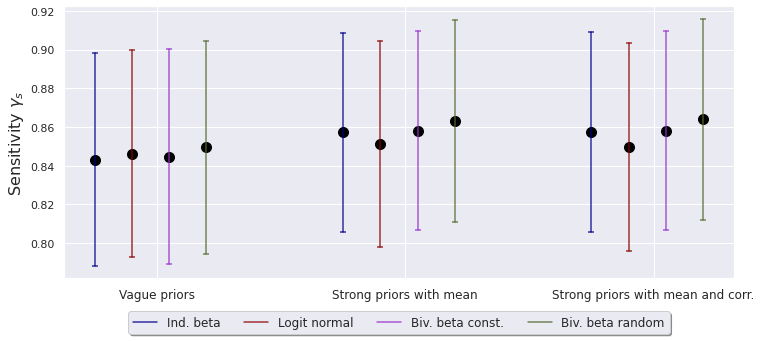

In [11]:
fig, ax = plt.subplots(figsize = (12,5))

colors = ['darkblue', 'darkred', 'darkorchid', 'darkolivegreen']
labels = ['Ind. beta', 'Logit normal', 'Biv. beta const.', 'Biv. beta random']
for i, name in enumerate(df1_grouped.index): 
    for j, df in enumerate([df1_grouped, df2_grouped, df3_grouped]): 
        if j == 0: label = labels[i]
        else: label = ''
        ax.plot([0.15*i+j,0.15*i+j], [df.loc[name, 'hdi_sens_lb'], df.loc[name, 'hdi_sens_ub']], 
                color = colors[i], alpha = 0.8, label=label)
        ax.scatter([0.15*i+j,0.15*i+j],[df.loc[name, 'hdi_sens_lb'], df.loc[name, 'hdi_sens_ub']], 
                   color = colors[i], alpha = 0.8, marker = '_')
        ax.scatter([0.15*i+j], [(df.loc[name, 'hdi_sens_lb']+df.loc[name, 'hdi_sens_ub'])/2], 
                   color = 'black', s = 100)
        
ax.legend(fontsize = 12, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel(r'Sensitivity $\gamma_s$', fontsize=16)

ax.set_xticks([0.25, 1.25, 2.25])
ax.set_xticklabels(labels=['Vague priors', 'Strong priors with mean', 'Strong priors with mean and corr.'], 
                   fontsize = 12)

plt.savefig("../images/comparing_hdi_prior_approaches_sens-spec.pdf", bbox_inches = "tight")
plt.show()